# Import Library

In [ ]:
!pip install scikit-optimize
!pip install xgboost
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Data Exploration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Modeling Machine Learning
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib # Save Model


# Import Data

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d aadarshvelu/aids-virus-infection-prediction --unzip

Dataset URL: https://www.kaggle.com/datasets/aadarshvelu/aids-virus-infection-prediction
License(s): CC0-1.0
  0% 0.00/1.63M [00:00<?, ?B/s]
100% 1.63M/1.63M [00:00<00:00, 464MB/s]


In [ ]:
df = pd.read_csv('/content/AIDS_Classification_50000.csv')

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      50000 non-null  int64  
 1   trt       50000 non-null  int64  
 2   age       50000 non-null  int64  
 3   wtkg      50000 non-null  float64
 4   hemo      50000 non-null  int64  
 5   homo      50000 non-null  int64  
 6   drugs     50000 non-null  int64  
 7   karnof    50000 non-null  int64  
 8   oprior    50000 non-null  int64  
 9   z30       50000 non-null  int64  
 10  preanti   50000 non-null  int64  
 11  race      50000 non-null  int64  
 12  gender    50000 non-null  int64  
 13  str2      50000 non-null  int64  
 14  strat     50000 non-null  int64  
 15  symptom   50000 non-null  int64  
 16  treat     50000 non-null  int64  
 17  offtrt    50000 non-null  int64  
 18  cd40      50000 non-null  int64  
 19  cd420     50000 non-null  int64  
 20  cd80      50000 non-null  in

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,1073,1,37,79.46339,0,1,0,100,0,1,...,1,2,0,1,0,322,469,882,754,1
1,324,0,33,73.02314,0,1,0,90,0,1,...,1,3,1,1,1,168,575,1035,1525,1
2,495,1,43,69.47793,0,1,0,100,0,1,...,1,1,0,0,0,377,333,1147,1088,1
3,1201,3,42,89.15934,0,1,0,100,1,1,...,1,3,0,0,0,238,324,775,1019,1
4,934,0,37,137.46581,0,1,0,100,0,0,...,0,3,0,0,1,500,443,1601,849,0


#Data Understanding

**Data Source:**

Dataset obtained from [AIDS Virus Infection Prediction 💉
](https://www.kaggle.com/datasets/aadarshvelu/aids-virus-infection-prediction/data)

**Data Information:**
* About Data: Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996.

* Amount of data: 50,000 rows

* Data format: Tabular (CSV)


**Column Explanation:**

Time and Key Outcome Information:

* **time**: Time until treatment failure or patient is no longer observed in the study (censoring). This is the primary time variable in survival analysis.
* **infected**: AIDS infection status of the patient at the end of the study (0=No, 1=Yes). This can be a target variable in some types of analysis.
* **offtrt**: Indicator of whether the patient stopped treatment before the specified time (0=No, 1=Yes).
---
Treatment Information:

* **trt**: Code indicating the type of antiretroviral treatment received by the patient (0=ZDV only, 1=ZDV+ddI, 2=ZDV+Zal, 3=ddI only).
* **treat**: Simplified version of the treatment indicator (0=ZDV only, 1=others).
* **oprior**: Whether the patient had received non-ZDV antiretroviral therapy before the study (0=No, 1=Yes).
* **z30**: Whether the patient used ZDV in the 30 days before a specific time point in the study (0=No, 1=Yes).
* **preanti**: Number of days the patient had received antiretroviral therapy before a specific time point.
* **str2**: Patient's experience with antiretroviral therapy (0=naive/never, 1=experienced).
* **strat**: Stratification category based on the length of the patient's experience with antiretroviral therapy (1='Antiretroviral Naive', 2='> 1 but <= 52 weeks of prior antiretroviral therapy', 3='> 52 weeks').
---
Personal Information:
* **age**: Patient's age at the start of the study (baseline) in years.
* **wtkg**: Patient's weight at the start of the study (baseline) in kilograms.
* **race**: Patient's race (0=White, 1=non-white).
* **gender**: Patient's gender (0=F/Female, 1=M/Male).
* **homo**: Whether the patient has a history of same-sex sexual activity (0=No, 1=Yes).
---
**Medical History:**
* **hemo**: Whether the patient has hemophilia (blood clotting disorder) (0=No, 1=Yes).
* **drugs**: Whether the patient has a history of illicit drug use by injection (0=No, 1=Yes).
* **symptom**: Whether the patient showed symptoms of illness at the start of the study (0=asymptomatic, 1=symptomatic).
---
Lab Results:

* **karnof**: Karnofsky score, a general measure to assess the patient's level of physical function (scale 0-100, higher is better) at baseline.
* **cd40**: Patient's CD4 cell count at baseline.
* **cd420**: Patient's CD4 cell count around 20 weeks after the start of the study.
* **cd80**: Patient's CD8 cell count at baseline.
* **cd820**: Patient's CD8 cell count around 20 weeks after the start of the study.

## EDA

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time,50000.0,877.369780,307.288688,66.00000,542.000000,1045.000000,1136.000000,1231.00000
trt,50000.0,1.384800,1.233272,0.00000,0.000000,1.000000,3.000000,3.00000
age,50000.0,34.164020,7.091152,12.00000,29.000000,34.000000,39.000000,68.00000
wtkg,50000.0,75.861991,12.028730,42.36162,68.253682,74.054115,81.142185,149.83087
hemo,50000.0,0.033480,0.179888,0.00000,0.000000,0.000000,0.000000,1.00000
homo,50000.0,0.653540,0.475847,0.00000,0.000000,1.000000,1.000000,1.00000
drugs,50000.0,0.132220,0.338733,0.00000,0.000000,0.000000,0.000000,1.00000
karnof,50000.0,96.831560,5.091788,76.00000,90.000000,100.000000,100.000000,100.00000
oprior,50000.0,0.042300,0.201275,0.00000,0.000000,0.000000,0.000000,1.00000
z30,50000.0,0.640880,0.479747,0.00000,0.000000,1.000000,1.000000,1.00000


The table above shows the distribution of data, but I’m gonna visualize it to get a better understanding in a simpler way.

In [ ]:
# Initialize Numerical and Categorical Columns
numerical_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820', 'karnof']
categorical_cols = [col for col in df.columns if col not in numerical_cols]

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Numerical Columns: ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820', 'karnof']
Categorical Columns: ['trt', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'infected']


Univariate Analysis for Numerical Columns:


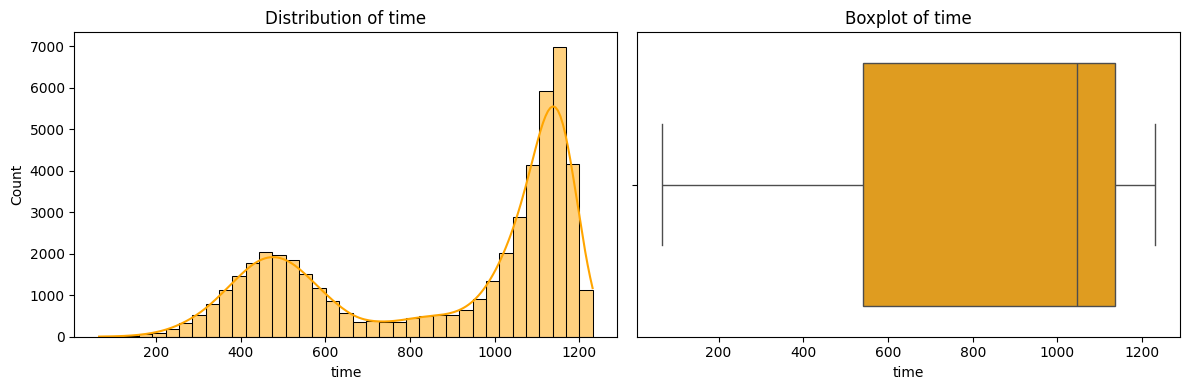

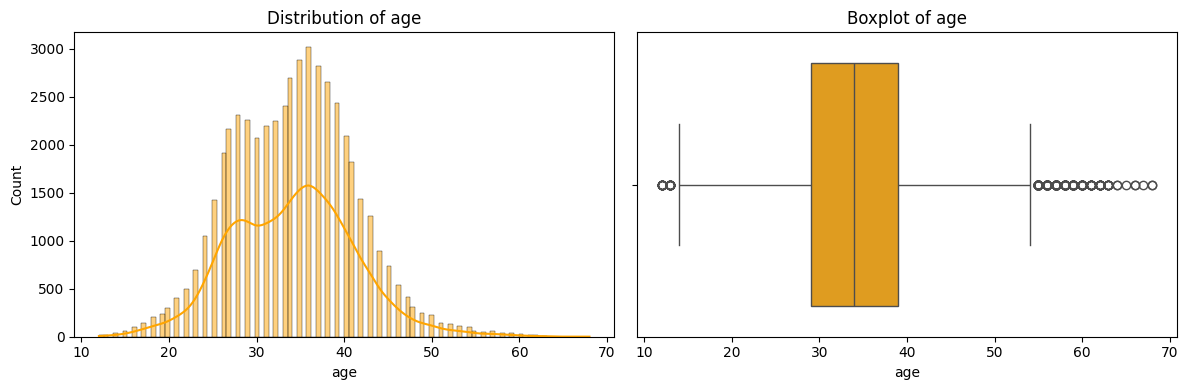

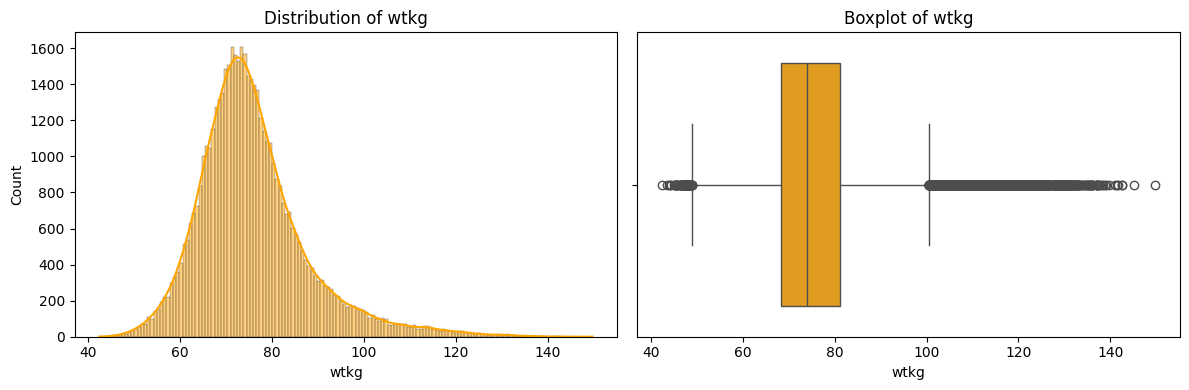

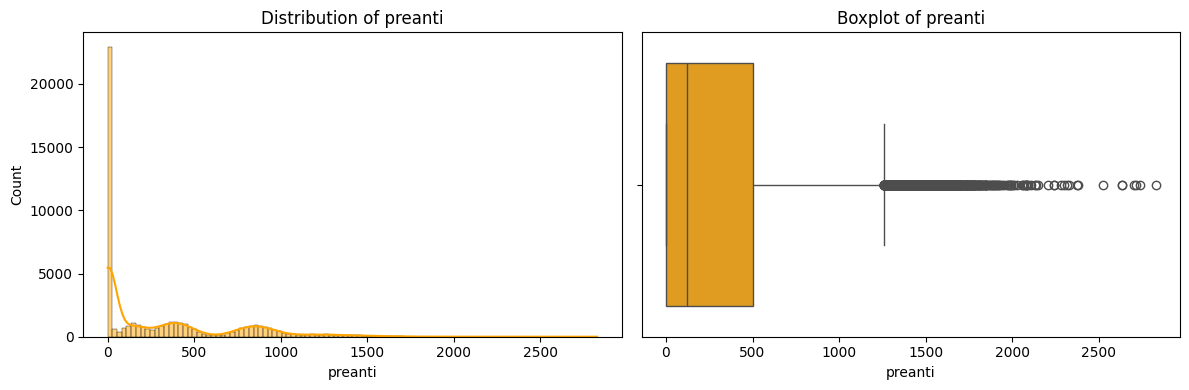

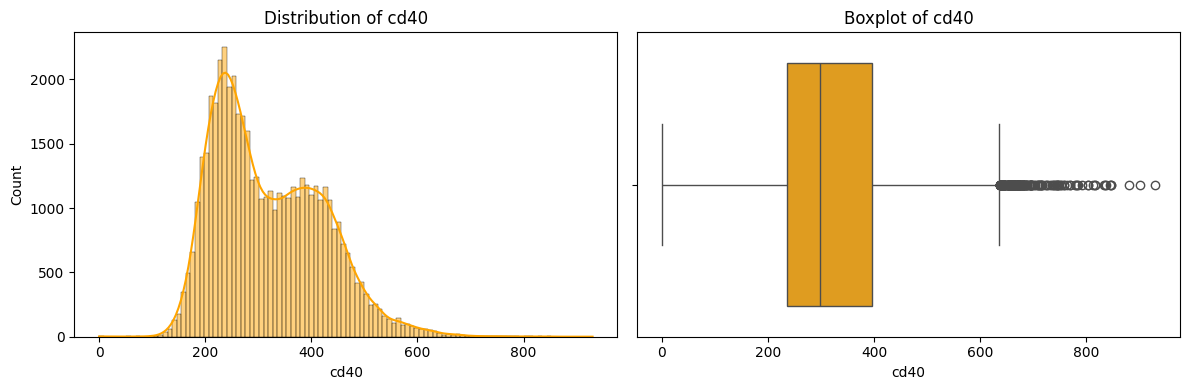

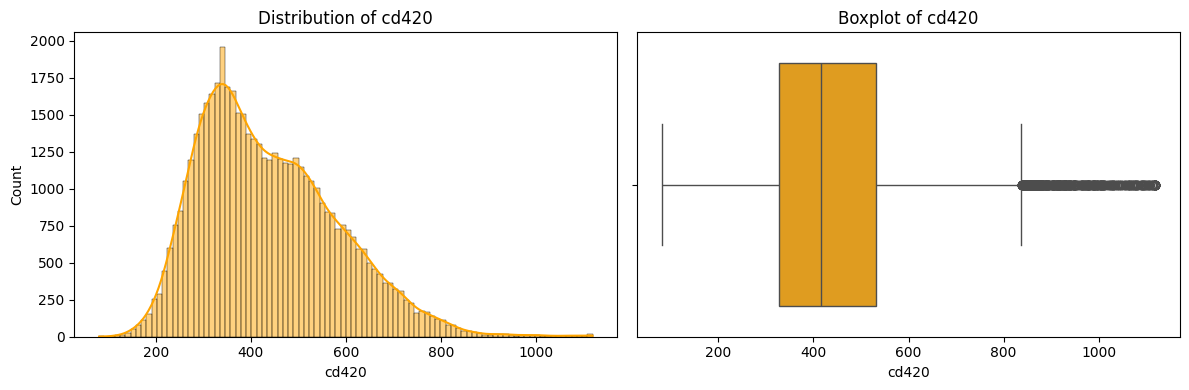

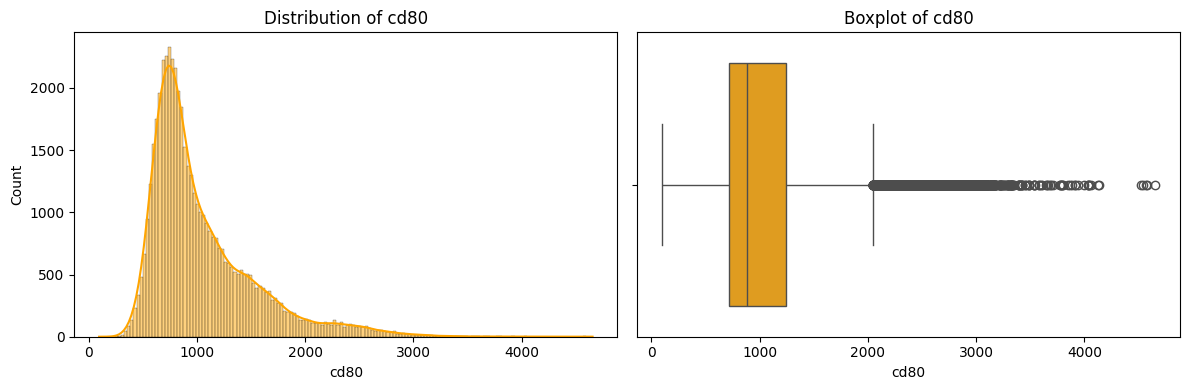

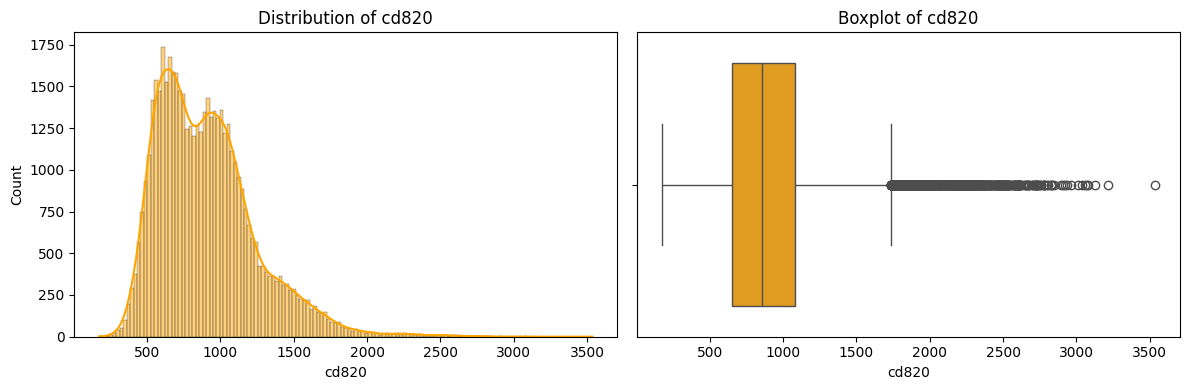

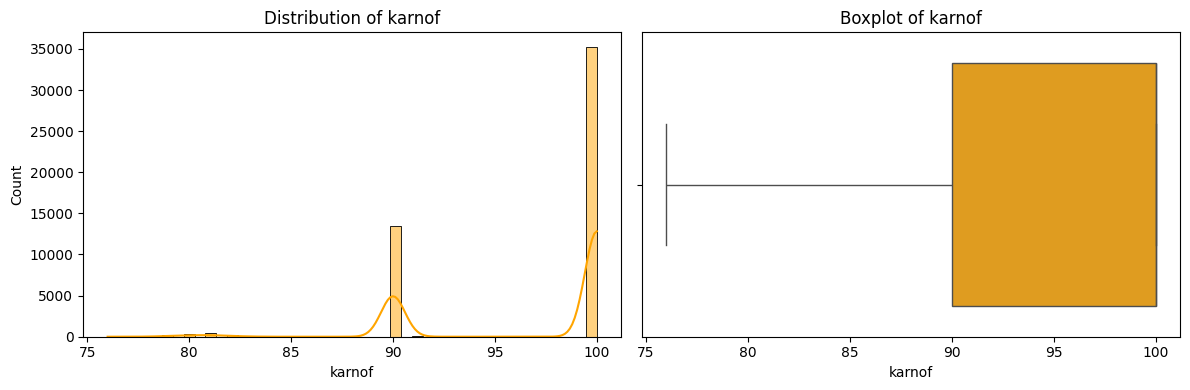


Univariate Analysis for Categorical Columns:


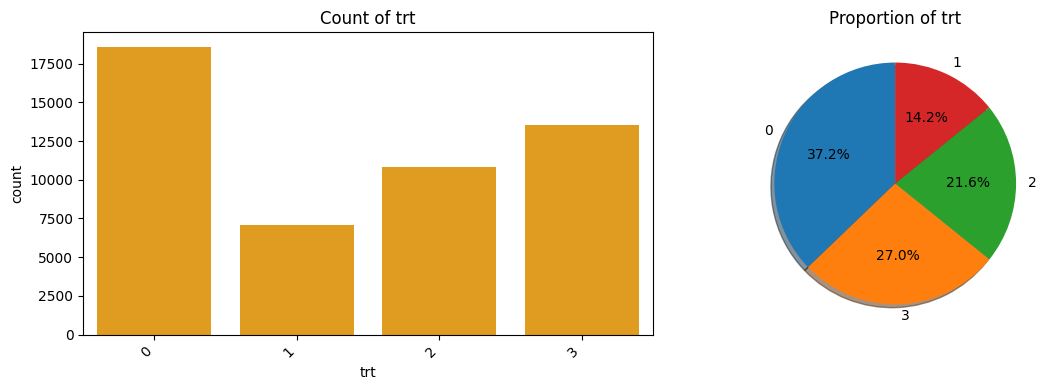

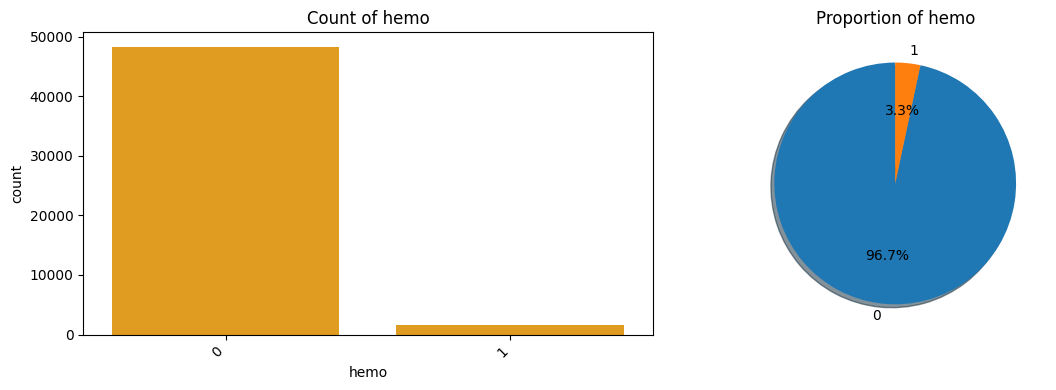

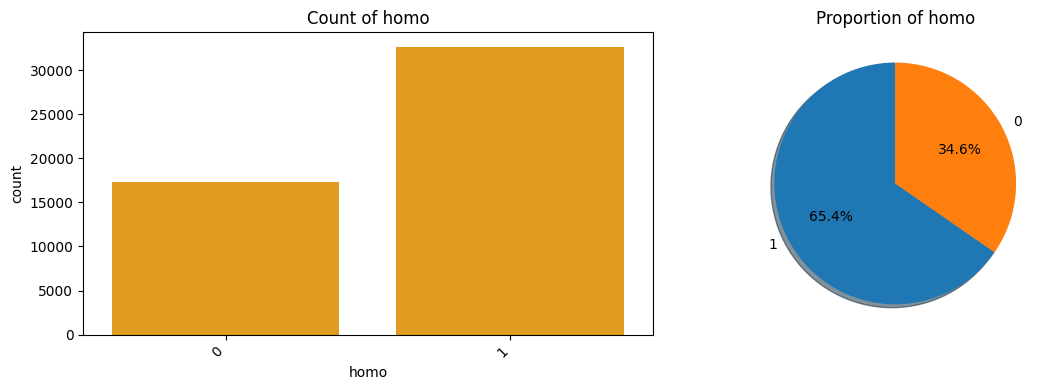

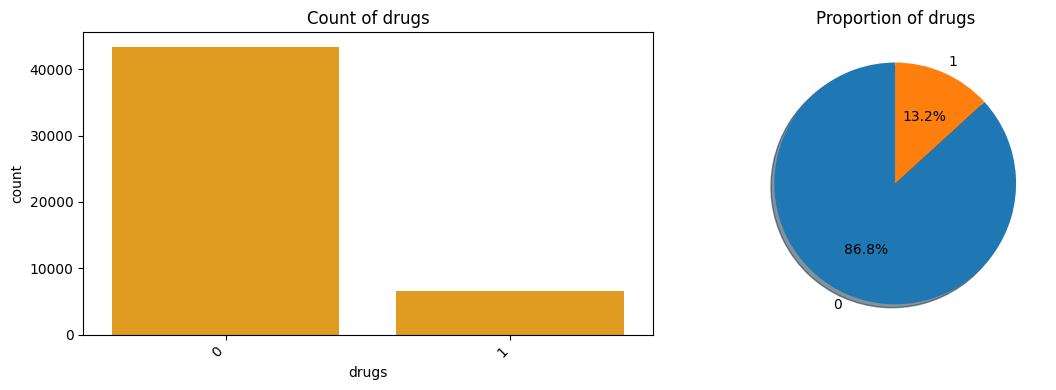

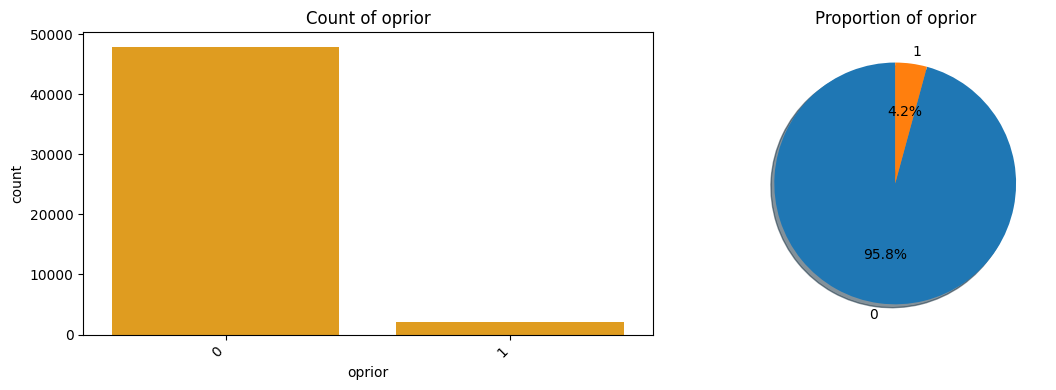

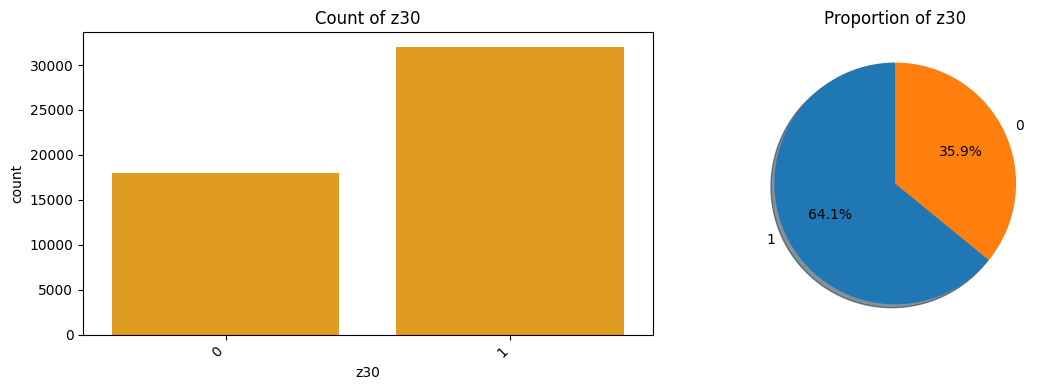

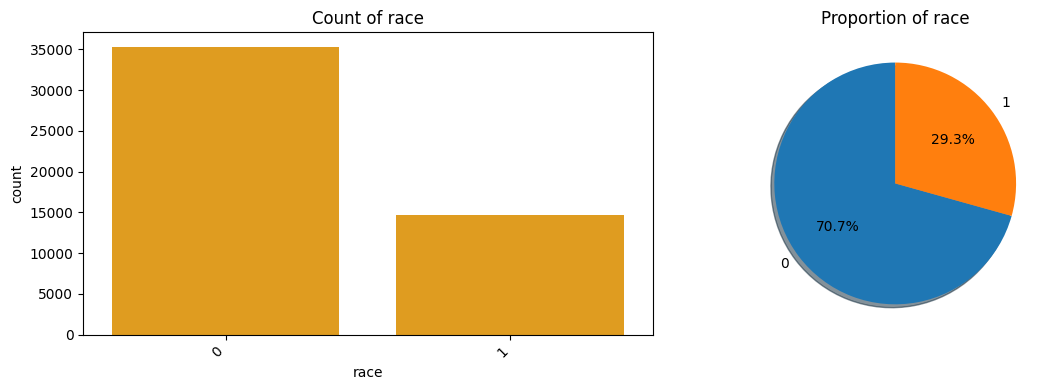

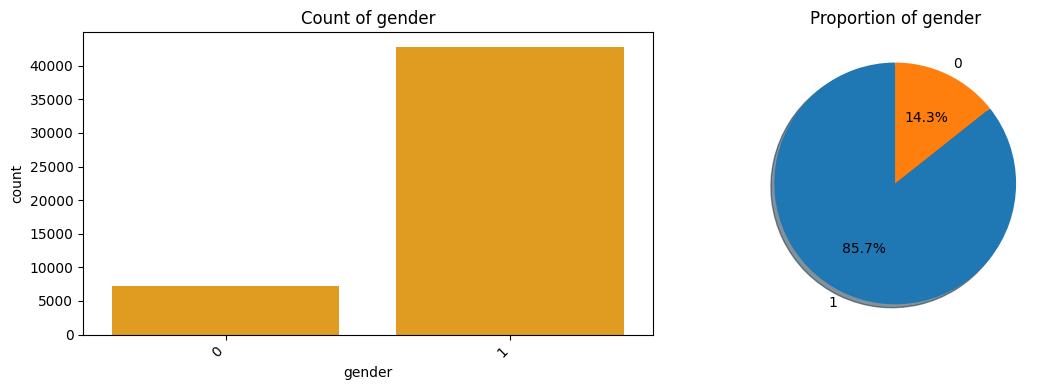

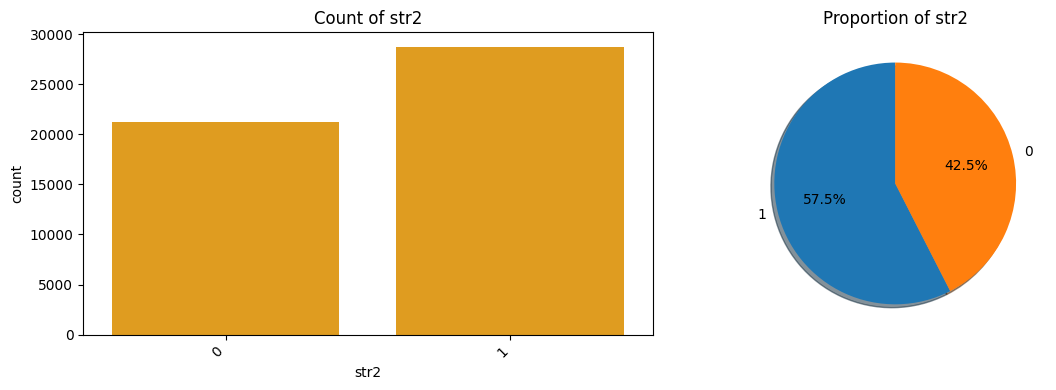

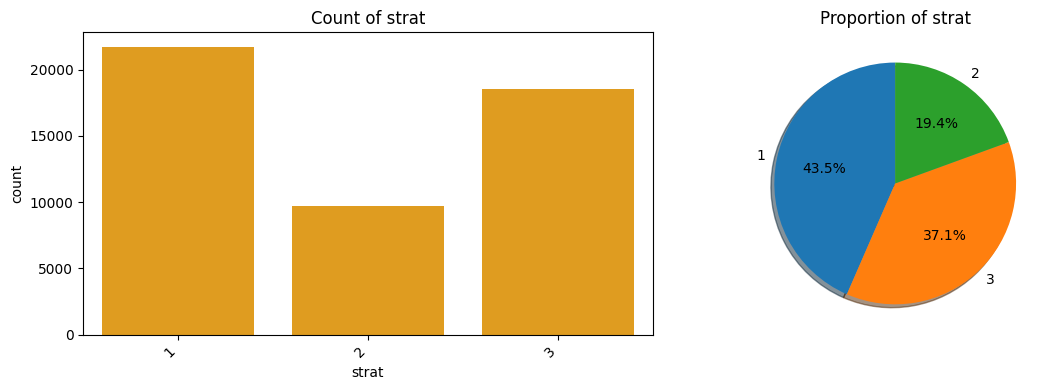

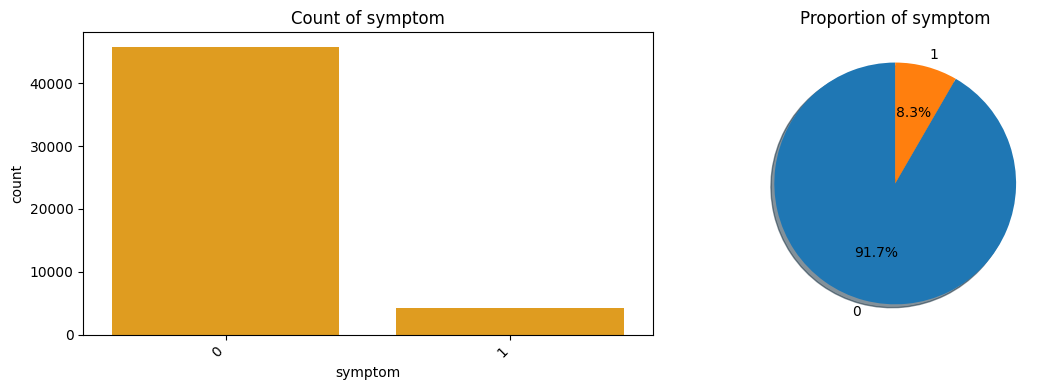

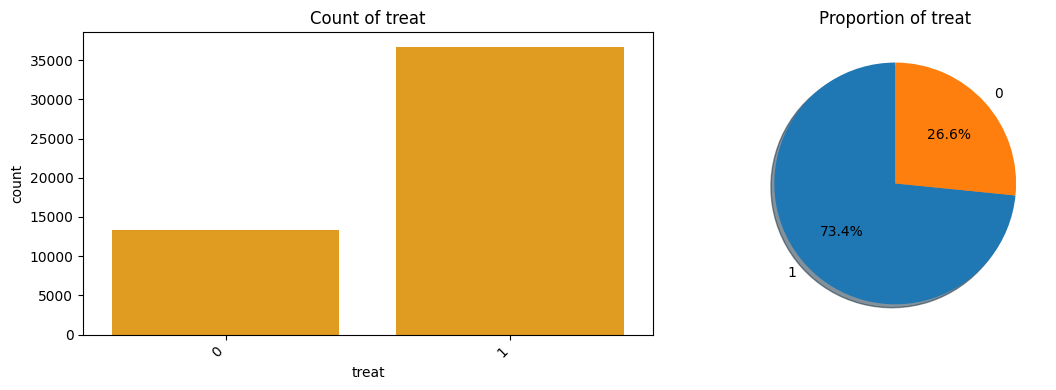

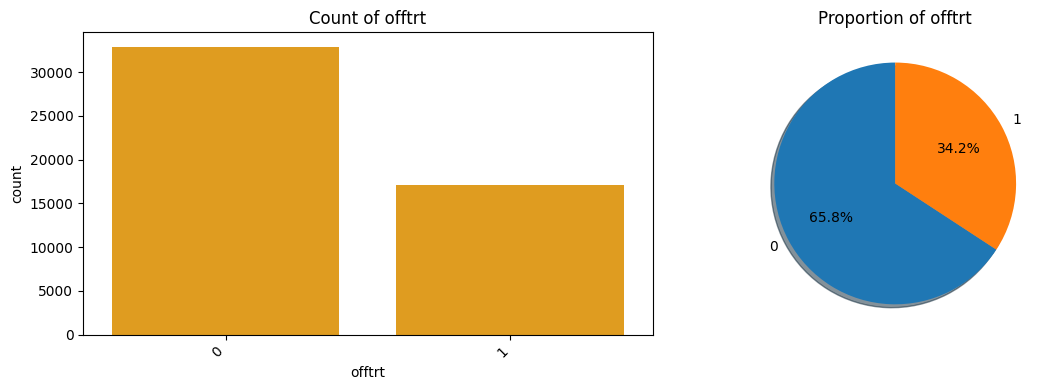

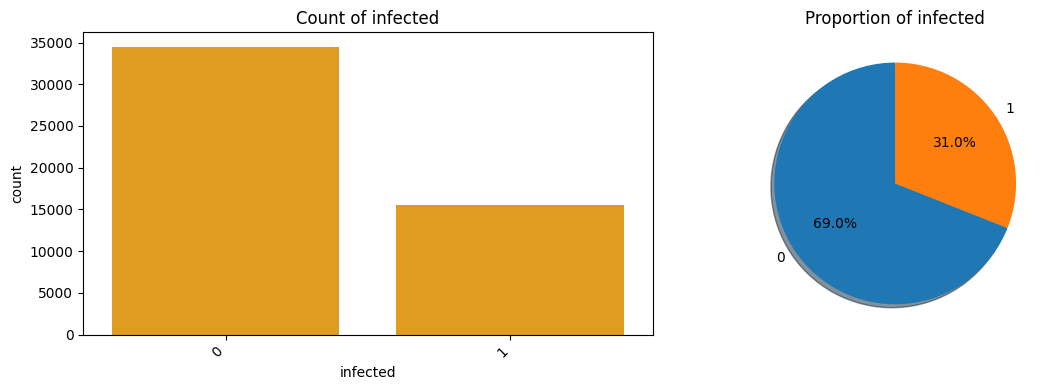

In [ ]:
def plot_univariate_numerical(df, column):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=column, kde=True, color = 'orange')
    plt.title(f'Distribution of {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x=column, color = 'orange')
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

def plot_univariate_categorical(df, column):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x=column, color = 'orange')
    plt.title(f'Count of {column}')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    df[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, shadow = True)
    plt.title(f'Proportion of {column}')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Univariate Analysis For Numerical Col
print("Univariate Analysis for Numerical Columns:")

for col in numerical_cols:
    plot_univariate_numerical(df, col)

# Univariate Analysis For Categorical Col
print("\nUnivariate Analysis for Categorical Columns:")
for col in categorical_cols:
    plot_univariate_categorical(df, col)



## Data Distribution Summary

#### 1. `Time`

Patients participated in the study for **66 to 1200 days**, with a **left-skewed distribution**.

#### 2. `Age`

Patients aged **10 to 70 years** joined the study, and the distribution is **fairly normal**.

#### 3. `Wktg` (Body Weight)

Patients had body weights ranging from **around 40 kg to over 140 kg**. The distribution is **slightly right-skewed**, though it appears somewhat normal. Since most data falls between **50 and 100 kg**, there are **a number of outliers**.

#### 4. `Preanti`

Use of antiretroviral drugs for pain relief in HIV/AIDS patients. The distribution is **right-skewed** with **many outliers**.

#### 5. `Cd40`

CD4 cell count (immune cells) at **baseline** ranged from **0 to over 800**, with a **fairly normal distribution**.

#### 6. `Cd420`

CD4 cell count **after 20 days** ranged from **above 0 to over 1000**, showing an **increase from baseline** with a **more normal distribution**, though **outliers still exist**.

#### 7. `Cd80`

Baseline CD8 cell count ranged from **0 to over 4000**, with a **right-skewed distribution**.

#### 8. `Cd820`

CD8 cell count **after 20 days** ranged from **above 0 to 3500**, showing a **decrease from baseline** and a **right-skewed distribution**.

#### 9. `Karnof`

Patient health scores ranged from **35 to 100**, with a **left-skewed distribution**.

---

### 📋 Categorical Data Summary

* `Trt`: 37.3% of patients were treated with **ZDV only**.
* `Hemo`: 96.5% of patients **do not have hemophilia**.
* `Homo`: 65% of participants **identify as homosexual**.
* `Drugs`: 86% of participants **do not use drugs**.
* `Oprior`: 95% of participants **did not receive non-ZDV antiretroviral therapy** before.
* `Z30`: 64% of patients **used ZDV in the past 30 days**.
* `Race`: 70% of participants are **White**.
* `Gender`: 85% of participants are **male**.
* `Str2`: 57% of participants **had previous antiretroviral treatment**.
* `Strat`:

  * 43% **never received any treatment**
  * 19% **had treatment for less than 52 weeks**
  * 37% **had treatment multiple times**
* `Symptom`: 91% of patients **reported no symptoms**.
* `Treat`: 73% of patients **used treatments beyond just ZDV**.
* `Offtreatment`: 65% of patients **did not stop treatment before 5 weeks**.
* `Infected`: 69% of participants were **not infected**, while 31% **were infected**.


## Conclusion

The dataset mostly shows **non-normal distributions**, and the target classes (**infected vs. not infected**) are **imbalanced**, with way more samples in the non-infected group. This can cause machine learning models to be biased toward the majority class.

To tackle this, I plan to:

- Apply **Log1p transformation** and **Robust Scaler** to handle **outliers** more effectively. These outliers seem like valid values, not random noise or errors, so we don’t want to just drop them.
- Perform **One-Hot Encoding** on categorical columns to make sure the model doesn't misinterpret category values as numeric relationships.
- Use **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the class distribution. This helps reduce bias and gives the model a fair chance to learn from the minority class.

These preprocessing steps are aimed at boosting model performance and making the predictions more fair and reliable.


#Data Preprocessing

During the data preprocessing phase, I applied several important steps to prepare the dataset for modeling:

1. **Data Cleaning**  
   This step involves handling "dirty" data, such as:
   - Removing **duplicate rows** that can bias the model.
   - Checking and handling **missing values**, although in this dataset, missing values were minimal or non-existent.

2. **Data Splitting**  
   The dataset was split into **training and testing sets** *before* any transformation, scaling, or encoding.  
  This is important to avoid **data leakage**, where the model might indirectly learn from the test data (like seeing the answer key).

3. **Data Transformation (Log1p)**  
   Some numerical features had **highly skewed distributions**. To address this, I applied the **Log1p transformation** to reduce skewness and help the model learn better patterns.

4. **Feature Scaling (Robust Scaler)**  
   After transformation, I used **Robust Scaler** for feature scaling.  
   This scaler is less sensitive to **outliers**, which is perfect since our data contains valid extreme values.

5. **One-Hot Encoding**  
   For categorical features, I used **One-Hot Encoding** to avoid misleading the model into thinking that higher category values mean "greater" (e.g., category 3 > 1).  
   This ensures categories are treated equally.

6. **SMOTE (Synthetic Minority Over-sampling Technique)**  
   The target variable (`infected`) was **imbalanced**, with far fewer positive cases.  
   So, I used **SMOTE** to synthetically generate new examples of the minority class, helping the model **learn more fairly** and avoid bias toward the majority class.


## Data Cleaning

1. Clean Duplicated Values

In [ ]:
df.drop_duplicates(inplace=True)

2. Check and Handling Missing Values


In [ ]:
df.isna().sum()

,0
time,0
trt,0
age,0
wtkg,0
hemo,0
homo,0
drugs,0
karnof,0
oprior,0
z30,0


there is no missing values.

## Data Splitting

The dataset was split into **85% training** and **15% testing**.  
This approach gives the model **more data to learn from** during training, which can lead to better generalization—especially when the dataset is relatively large like this one (50,000 rows).


In [ ]:
X = df.drop('infected', axis=1)
y = df['infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

print("Original shapes:")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Original shapes:
Shape of X_train: (42500, 22)
Shape of X_test: (7500, 22)


Copy The data to avoid SettingWithCopyWarning

In [ ]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

## Data Transformation : Using Logp1

Apply log1p to Scale the data to more normal distribution

In [ ]:
numerical_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820', 'karnof']
categorical_cols = [col for col in X_train_processed.columns if col not in numerical_cols]

print(f"\nNumerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")


Numerical columns: ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820', 'karnof']
Categorical columns: ['trt', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt']


In [ ]:
print("\nProcessing numerical features...")
print("Applying Log1p transformation...")
X_train_processed[numerical_cols] = np.log1p(X_train_processed[numerical_cols])
X_test_processed[numerical_cols] = np.log1p(X_test_processed[numerical_cols])


Processing numerical features...
Applying Log1p transformation...


## Data Scalling : Using Robust Scaller

In [ ]:
print("Applying RobustScaler...")
rs = RobustScaler()
X_train_processed[numerical_cols] = rs.fit_transform(X_train_processed[numerical_cols])
X_test_processed[numerical_cols] = rs.transform(X_test_processed[numerical_cols])

Applying RobustScaler...


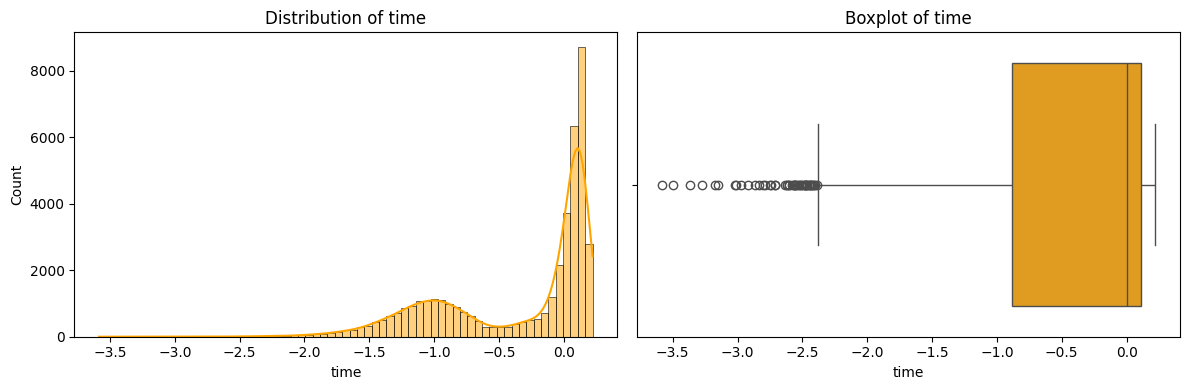

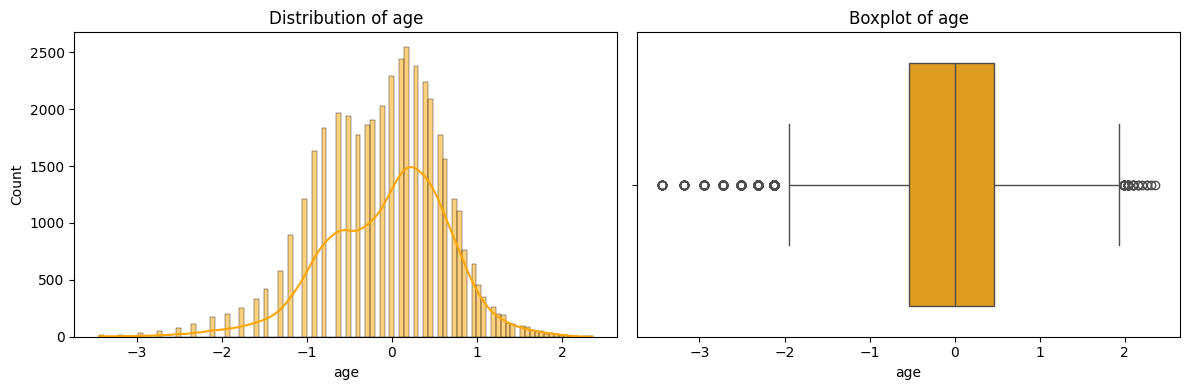

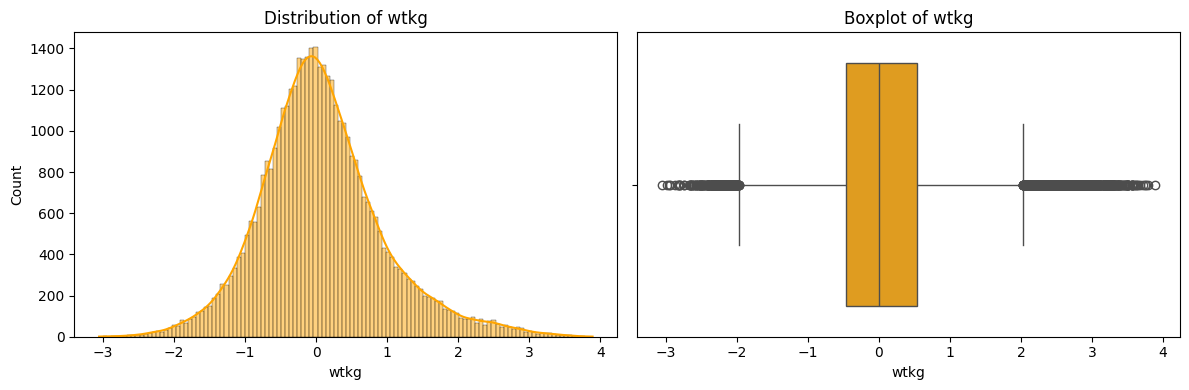

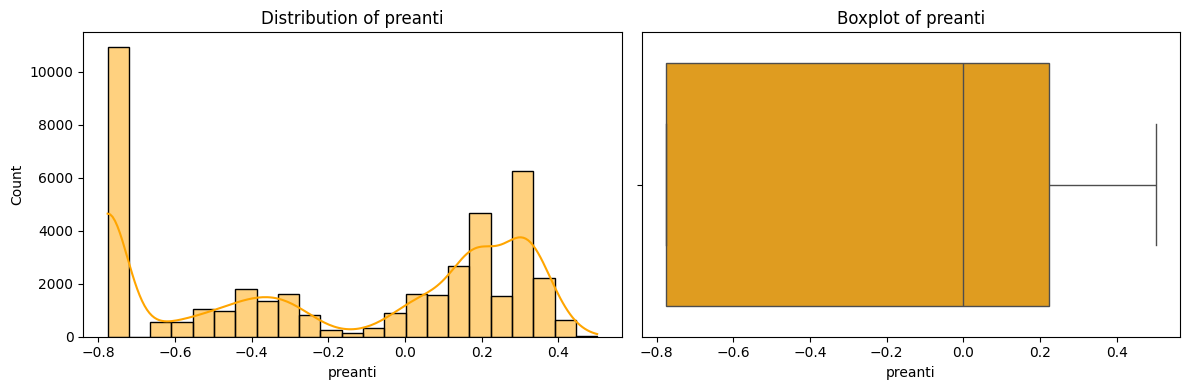

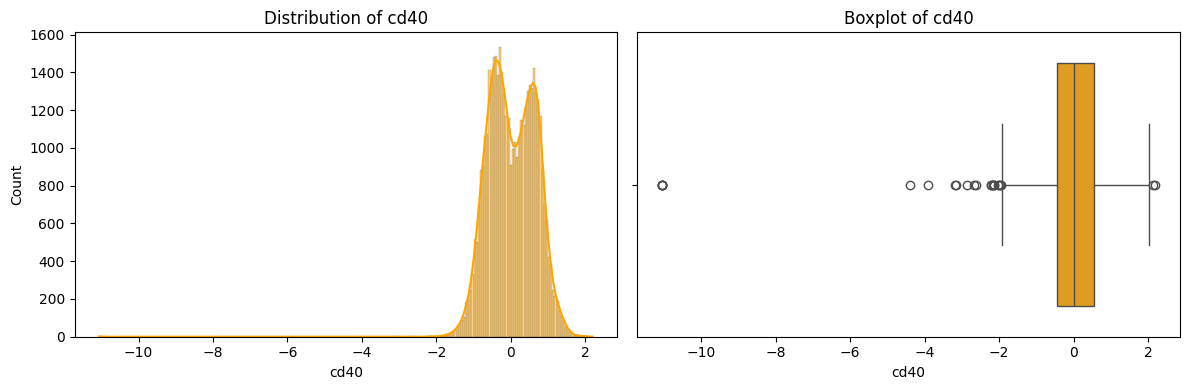

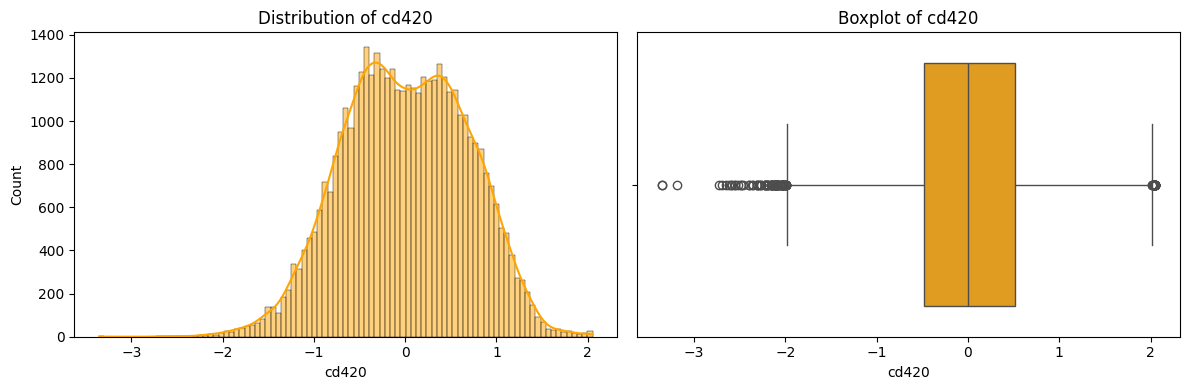

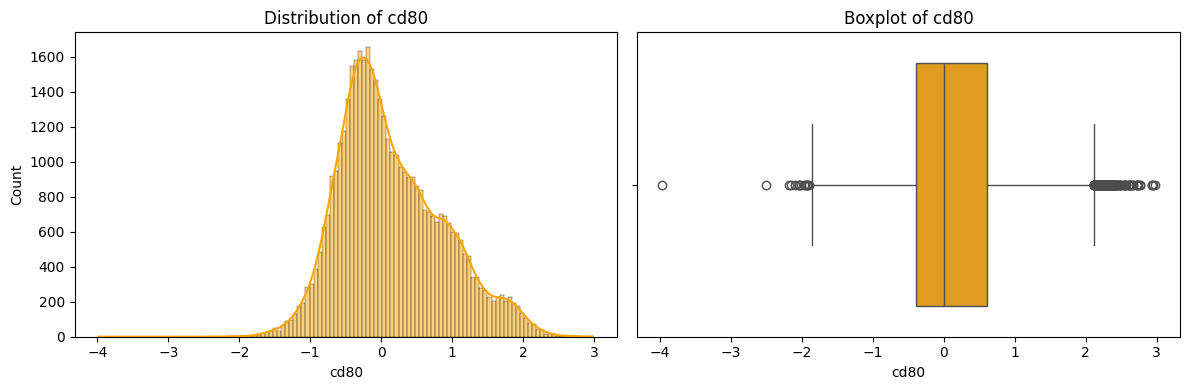

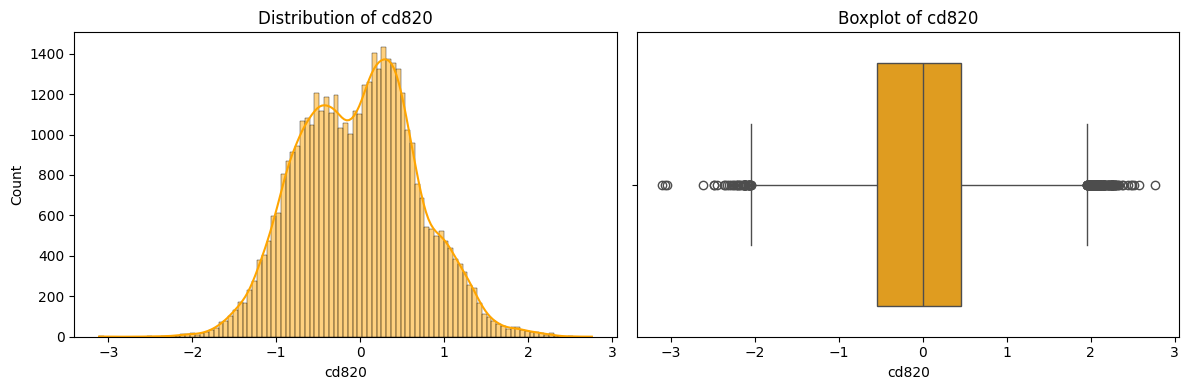

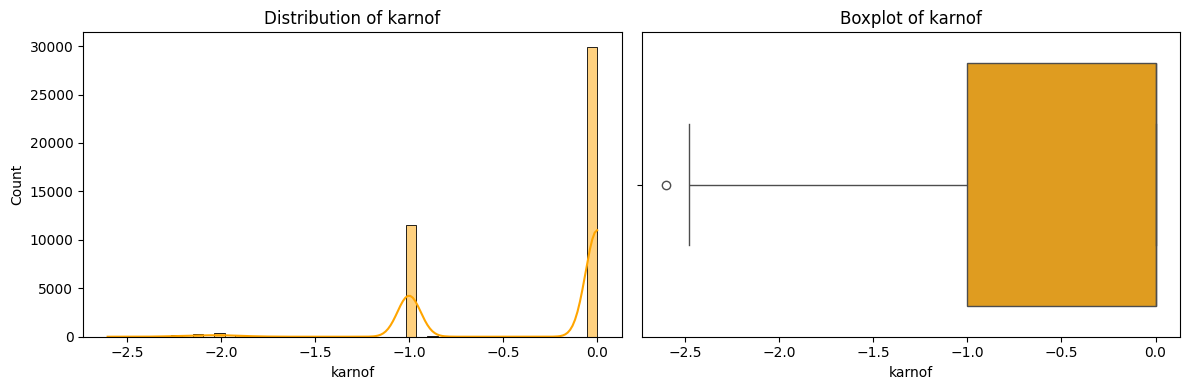

In [ ]:
for col in numerical_cols:
    plot_univariate_numerical(X_train_processed, col)

After applying **log transformation** and **scaling**, the data distribution has become **more normalized** compared to the original skewed state.  
This transformation is expected to help the model **learn patterns more effectively**, which can potentially lead to **higher accuracy and better generalization**.

## One Hot Encoding to Categorical Feature

In [ ]:
print("\nProcessing categorical features using One-Hot Encoding...")
if categorical_cols:
    X_train_processed = pd.get_dummies(X_train_processed, columns=categorical_cols, drop_first=True, prefix=categorical_cols, prefix_sep='_')
    X_test_processed = pd.get_dummies(X_test_processed, columns=categorical_cols, drop_first=True, prefix=categorical_cols, prefix_sep='_')
-

    train_cols = X_train_processed.columns
    test_cols = X_test_processed.columns

    for col in train_cols:
        if col not in test_cols:
            X_test_processed[col] = 0

    X_test_processed = X_test_processed[train_cols]

    print("Shape of X_train after OHE:", X_train_processed.shape)
    print("Shape of X_test after OHE:", X_test_processed.shape)
else:
    print("No categorical columns to encode.")



Processing categorical features using One-Hot Encoding...
Shape of X_train after OHE: (42500, 25)
Shape of X_test after OHE: (7500, 25)


In [ ]:
X_train_processed.head().T

,28991,44261,39807,927,39652
time,-1.150372,-1.015093,0.090074,-1.754625,-1.094046
age,0.376157,0.285865,-0.311497,0.464163,1.75574
wtkg,-0.590355,-1.173191,-1.380225,0.704798,-0.462399
karnof,0.0,0.0,-1.0,0.0,-1.0
preanti,0.233037,0.015899,-0.441723,0.327758,-0.052788
cd40,-0.766686,0.231186,0.656844,-0.947605,-0.182817
cd420,-0.943127,-0.139101,0.88599,0.292232,0.283563
cd80,0.021147,0.298851,-0.211531,-0.388638,1.370987
cd820,0.597938,-0.623918,0.434085,-0.700499,-0.473427
trt_1,False,True,False,False,False


In [ ]:
X_train_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
time,42500.0,-0.347166,0.588937,-3.583928,-0.887124,0.0,0.112876,0.221457
age,42500.0,-0.056621,0.726151,-3.442685,-0.535837,0.0,0.464163,2.359405
wtkg,42500.0,0.072782,0.868107,-3.057849,-0.469999,0.0,0.530001,3.890629
karnof,42500.0,-0.320152,0.517747,-2.602268,-1.000000,0.0,0.000000,0.000000
preanti,42500.0,-0.174449,0.442094,-0.775873,-0.775873,0.0,0.224127,0.501258
cd40,42500.0,0.026846,0.628800,-11.056496,-0.456936,0.0,0.543064,2.195249
cd420,42500.0,0.003684,0.682638,-3.352893,-0.486457,0.0,0.513543,2.052821
cd80,42500.0,0.139104,0.733802,-3.973648,-0.388638,0.0,0.611362,2.979191
cd820,42500.0,-0.020717,0.700578,-3.110350,-0.544214,0.0,0.455786,2.762279


## Applying Smote to Handling Imbalance Data

In [ ]:
print("\nApplying SMOTE to handle imbalanced data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("\nNew Data Shape after SMOTE:")
print("Shape of X_train_smote:", X_train_smote.shape)
print("Shape of y_train_smote:", y_train_smote.shape)

print('\nClass Distribution Before and After Smote:')
print("Before (original y_train):")
if isinstance(y_train, np.ndarray):
    print(pd.Series(y_train).value_counts(normalize=True))
else:
    print(y_train.value_counts(normalize=True))

print('=' * 50)
print("After (y_train_smote):")
print(pd.Series(y_train_smote).value_counts(normalize=True))


Applying SMOTE to handle imbalanced data...

New Data Shape after SMOTE:
Shape of X_train_smote: (58640, 25)
Shape of y_train_smote: (58640,)

Class Distribution Before and After Smote:
Before (original y_train):
infected
0    0.689882
1    0.310118
Name: proportion, dtype: float64
After (y_train_smote):
infected
0    0.5
1    0.5
Name: proportion, dtype: float64


After applying **SMOTE (Synthetic Minority Over-sampling Technique)**, the target variable `infected` is now **balanced**, unlike before where the data was heavily skewed toward the non-infected class.  

This balancing step is crucial to help the model **avoid bias** toward the majority class and improve its ability to correctly identify **positive cases**, resulting in a more **fair and accurate prediction**.

# Modelling & Evaluation

In the modeling phase, I used **three different algorithms** to compare their performance:

1. **Logistic Regression**
2. **Random Forest**
3. **XGBoost**

To ensure that the model generalizes well, I also applied **cross-validation** on the training data (`X_train` and `y_train`). Here, I used **K-Fold Cross Validation** with `k=5`, which means the data is split into 5 folds, and the model is trained and validated 5 times—each time using a different fold for validation and the rest for training.

The main goal of using multiple algorithms is to find the **best-performing model**, evaluated primarily using the **F1 Score**, since this metric is more suitable for **imbalanced classification problems** like this one.

By using this approach, I hope to select a model that’s not only accurate, but also **balanced** in identifying both positive and negative AIDS cases.


In [ ]:
# === DEFINE MODELS ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42) # Added solver for consistency if needed
}

# Variables to keep track of the best model
best_model_name = None
best_model_object = None
best_cv_f1_score = 0.0  # Initialize with a low value

for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    print('Model Evaluation : ')
    print('=' * 50)

    # Cross Validation (on SMOTE-augmented training set)
    cv_scores = cross_val_score(
        model, X_train_smote, y_train_smote, cv=5, scoring='f1', n_jobs=-1
    )
    mean_cv_f1 = cv_scores.mean()
    print(f"📊 CV F1 Scores: {cv_scores}")
    print(f"📈 CV F1 Mean: {mean_cv_f1:.4f}")

    # Fit final model (on all SMOTE-augmented training data)
    model.fit(X_train_smote, y_train_smote)

    # Predict on test data (original, not SMOTE'd)
    y_pred = model.predict(X_test_processed)

    # Print classification report
    print("🧾 Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print('=' * 50)

    # Check if this model is the best so far based on mean CV F1 score
    if mean_cv_f1 > best_cv_f1_score:
        best_cv_f1_score = mean_cv_f1
        best_model_object = model # Store the actual trained model object
        best_model_name = name
        print(f"🌟 New best model found: {name} with Mean CV F1: {best_cv_f1_score:.4f}")

# After the loop, save the best model
if best_model_object is not None:
    model_filename = f"{best_model_name.replace(' ', '_').lower()}_best_model.joblib"
    joblib.dump(best_model_object, model_filename)
    print(f"\n🏆 Best performing model '{best_model_name}' was saved as '{model_filename}' (Mean CV F1: {best_cv_f1_score:.4f})")
else:
    print("\nNo models were trained or no best model identified.")


🔍 Model: Random Forest
Model Evaluation : 
📊 CV F1 Scores: [0.68312016 0.67214762 0.79660469 0.82564943 0.82987358]
📈 CV F1 Mean: 0.7615
🧾 Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      5174
           1       0.49      0.50      0.50      2326

    accuracy                           0.68      7500
   macro avg       0.63      0.63      0.63      7500
weighted avg       0.69      0.68      0.68      7500

🌟 New best model found: Random Forest with Mean CV F1: 0.7615

🔍 Model: XGBoost
Model Evaluation : 
📊 CV F1 Scores: [0.48486886 0.47934988 0.78750725 0.83640933 0.83312362]
📈 CV F1 Mean: 0.6843
🧾 Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      5174
           1       0.49      0.44      0.46      2326

    accuracy                           0.68      7500
   macro avg       0.62      0.62      0.62      7500
weighted 

##Hyperparameter Optimization with Bayesian Search

To enhance model performance, I performed **Hyperparameter Optimization** using **BayesianSearchCV**.

**Purpose:**
- To find the **best combination of hyperparameters** for the **Random Forest** model
- Improve the model’s performance beyond the baseline
- Avoid manual trial-and-error by using a smarter and more efficient search method

**How Bayesian Search Works:**
Bayesian Search tries to understand the **relationship between parameters and model performance**, making the search process **more intelligent and efficient** compared to standard Grid Search or Random Search.

The optimized model will then be used to:
- Retrain on the training set
- Make predictions on the test set

**Evaluation:**
If the model’s performance after tuning with **BayesianSearchCV** shows **improvement** (e.g., a higher F1 Score for the positive AIDS class), then this tuned model will be selected as the **final model**.

However, if the performance **does not improve**, the **baseline model** will be retained as the main model.


In [ ]:
param_space = {
    'n_estimators': Integer(100, 300),  # Number of trees in the forest
    'max_depth': Integer(5, 30),      # Maximum depth of the trees
    'min_samples_split': Integer(2, 5), # Minimum number of samples required to split an internal node
    'min_samples_leaf': Integer(1, 5),   # Minimum number of samples required to be at a leaf node
    'criterion': ['gini']    # The function to measure the quality of a split
}

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42), # Use the same model type as the best one
    search_spaces=param_space,
    n_iter=15,      # Number of parameter settings that are sampled. Increase for better results.
    cv=5,           # Cross-validation folds
    scoring='f1',   # Metric to optimize
    n_jobs=-1,      # Use all available cores
    random_state=42 # for reproducibility
)

print("Performing BayesSearchCV for Random Forest...")
# Perform the search on the SMOTE-augmented training data
bayes_search.fit(X_train_smote, y_train_smote)

print("\nBayesSearchCV complete.")

# Get the best hyperparameters found
print("\nBest parameters found by BayesSearchCV:")
print(bayes_search.best_params_)

# Evaluate the best estimator found by BayesSearchCV on the original test set
best_rf_bayes = bayes_search.best_estimator_
y_pred_bayes = best_rf_bayes.predict(X_test_processed)

print("\nEvaluation of the best RandomForest model found by BayesSearchCV on the test set:")
print(classification_report(y_test, y_pred_bayes))

# Optional: Save the best model from BayesSearchCV
model_filename_tuned = f"random_forest_bayes_tuned_model.joblib"
joblib.dump(best_rf_bayes, model_filename_tuned)
print(f"\nTuned RandomForest model saved as '{model_filename_tuned}'")

Performing BayesSearchCV for Random Forest...

BayesSearchCV complete.

Best parameters found by BayesSearchCV:
OrderedDict([('criterion', 'gini'), ('max_depth', 25), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 299)])

Evaluation of the best RandomForest model found by BayesSearchCV on the test set:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      5174
           1       0.48      0.52      0.50      2326

    accuracy                           0.68      7500
   macro avg       0.63      0.64      0.63      7500
weighted avg       0.69      0.68      0.68      7500


Tuned RandomForest model saved as 'random_forest_bayes_tuned_model.joblib'


After trying hyperparameter optimization using Bayesian Search, it turns out that the baseline model performed better.
So, just like the original plan, I decided to stick with the baseline model as the main model for this project.

##  Final Model & Performance Result

At the end of the modeling process, the **Random Forest** algorithm showed the **best performance** among the three models tested. Here's the result breakdown:

**🔍 Model: Random Forest**

**📊 Cross-Validation F1 Scores:**

- **Average CV F1 Score:** **0.7615**
---

**🧾 Classification Report on Test Set:**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0 (Not Infected)** | 0.77 | 0.76 | 0.77 | 5174 |
| **1 (Infected)**     | 0.49 | 0.50 | 0.50 | 2326 |

- **Overall Accuracy:** 68%
- **Macro Avg F1 Score:** 0.63
- **Weighted Avg F1 Score:** 0.68

---

**Interpretation & Next Steps**

Even though Random Forest came out as the best model, we can see that:

- The **model still struggles** to correctly classify the **positive AIDS cases**, only reaching an F1 Score of **0.50** on class `1`.
- **Overall accuracy is just 68%**, which isn't very strong considering the sensitive nature of the prediction.

**Things to Improve:**

- **More Data**: The model might benefit from more representative samples—especially more positive class examples.
- **Data Quality Check**: Recheck data integrity to make sure the inputs are valid and make sense.
- **Try Ensemble Methods or Deep Learning Models**: If traditional ML models still underperform, try other techniques like stacking or neural nets.
